In [501]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV 
from sklearn import gaussian_process
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import datetime
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier as DTC
plt.style.use('ggplot')

%matplotlib inline


In [413]:
s_2015 = pd.read_csv("data/input_2015.csv")
s_2016 = pd.read_csv("data/input_2016.csv")
citi = pd.read_csv("data/city_charac.csv")

In [414]:
citi["geo_location"] = citi["geo_location"].apply(lambda x: x.lower())

In [415]:
char_dict = citi.drop(["Unnamed: 0", "lat", 
           "game_center", 
           "lon", "geometry"], axis=1).set_index("geo_location") \
           .T.to_dict("list")

In [416]:
for key in char_dict:
    char_dict[key][0] = float(char_dict[key][0].replace(",", ""))
    char_dict[key][2] = float(char_dict[key][2].replace(",", ""))
    char_dict[key][3] = float(char_dict[key][3].replace(",", ""))

In [417]:
def process(data):  
    data = data.drop("Unnamed: 0", axis = 1)
    data = data.reset_index(drop = 1)
    data["date"] = pd.to_datetime(data["date"])
    data["mon"] = data["date"].apply(lambda x: x.month)
    data["day"] = data["date"].apply(lambda x: x.day)
    data["time"] = data["date"].apply(lambda x: x.hour)
    data["dow"] = data["date"].dt.dayofweek
    data["night"] = data["time"].apply(lambda x: 1 if x >= 19 else 0)
    data["weekday"] = data["dow"].apply(lambda x: 1 if (x>=0) & (x<=4) else 0)
    data["April"] = data["date"].apply(lambda x: 1 if x.month == 4 else 0)
    data["May"] = data["date"].apply(lambda x: 1 if x.month == 5 else 0)
    data["June"] = data["date"].apply(lambda x: 1 if x.month == 6 else 0)
    data["July"] = data["date"].apply(lambda x: 1 if x.month == 7 else 0)
    data["August"] = data["date"].apply(lambda x: 1 if x.month == 8 else 0)
    data["September"] = data["date"].apply(lambda x: 1 if x.month == 9 else 0)
    #data["visit_code"] = data["guest"].apply(lambda x: refer[x])
    #data["home_code"] = data["home"].apply(lambda x: refer[x])
    
    data["attendace_ratio"] = data.attendance / data.capacity
    return data

In [418]:
train = process(s_2015)
test = process(s_2016)

In [419]:
train = train[train["date"] >= datetime.date(2015, 10, 27)]
test = test[test["date"] >= datetime.date(2016, 10, 25)]

In [420]:
refer = dict(zip(pd.concat([train["home"], train["guest"],
                           test["home"], test["home"]]), 
               pd.Categorical(pd.concat([train["home"], train["guest"],
                           test["home"], test["home"]])).codes)) ## team code
pos = dict(zip(pd.concat([s_2015["game_center"], s_2016["game_center"]]), 
               pd.Categorical(pd.concat([s_2015["game_center"], s_2016["game_center"]])).codes))

In [421]:
def trans_label(data):
    data["pos"] = data["game_center"].apply(lambda x: pos[x])
    data["visit_code"] = data["guest"].apply(lambda x: refer[x])
    data["home_code"] = data["home"].apply(lambda x: refer[x])
    return data

In [422]:
train = trans_label(train)
test = trans_label(test)

In [423]:
Xnames = ['capacity', 'streak_home', 'streak_guest', 'mon',
       'day', 'time', 'dow', 'night', 'weekday', 'April', 'May', 'June',
       'July', 'August', 'September', 'pos', 'home_code', 'visit_code', 
       "popu", "land_miles", "density", "income"]

In [424]:
def merge_char(data):
    data["popu"] = data["geo_location"].apply(lambda x: char_dict[x.lower()][0])
    data["land_miles"] = data["geo_location"].apply(lambda x: char_dict[x.lower()][1])
    data["density"] = data["geo_location"].apply(lambda x: char_dict[x.lower()][2])
    data["income"] = data["geo_location"].apply(lambda x: char_dict[x.lower()][3])
    return data

In [425]:
train = merge_char(train)

In [426]:
test = merge_char(test)

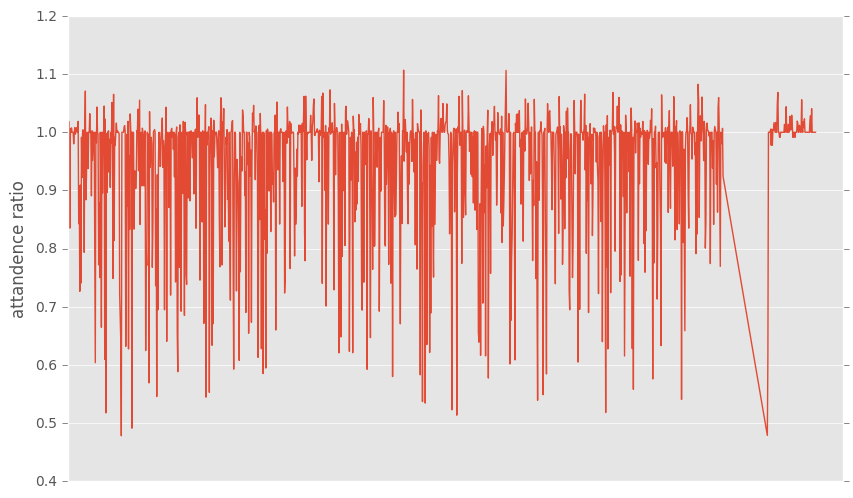

In [435]:
plt.figure(figsize = (10, 6))
plt.plot(train["attendace_ratio"])
plt.xticks([])
plt.ylabel("attandence ratio")
plt.savefig("ratio_plot.png", dpi=600)

In [436]:
(y_train == 1).sum()/len(y_train)

0.77672955974842772

In [362]:
Xtrain = train[Xnames]
Xtest = test[Xnames]
y_train = train["attendace_ratio"].copy()
y_test = test["attendace_ratio"].copy()

In [333]:
train.columns

Index(['Unnamed: 0.1', 'date', 'game_center', 'geo_location', 'attendance',
       'capacity', 'home', 'guest', 'streak_home', 'streak_guest', 'mon',
       'day', 'time', 'dow', 'night', 'weekday', 'April', 'May', 'June',
       'July', 'August', 'September', 'attendace_ratio', 'pos', 'visit_code',
       'home_code', 'popu', 'land_miles', 'density', 'income'],
      dtype='object')

In [369]:
def make_class(data):
    data[data >= 0.9] = 1
    data[data < 0.9] = 0
    return data

In [370]:
y_train = make_class(y_train)
y_test = make_class(y_test)

/Users/wyappff/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/wyappff/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


#### Random forest trees

In [372]:
rfc = RandomForestClassifier()
params = {
    "max_depth":range(10, 200, 10),
    "max_features":["auto", "sqrt", "log2"],
    "n_estimators":range(100, 1000, 50),
}
cv_rf = GridSearchCV(estimator=rfc, param_grid=params,
                     scoring="roc_auc", n_jobs = -1, cv=5, verbose=5)
cv_rf.fit(Xtrain, y_train)

Fitting 5 folds for each of 1026 candidates, totalling 5130 fits
[CV] max_depth=10, max_features=auto, n_estimators=100 ...............
[CV] max_depth=10, max_features=auto, n_estimators=100 ...............
[CV] max_depth=10, max_features=auto, n_estimators=100 ...............
[CV] max_depth=10, max_features=auto, n_estimators=100 ...............
[CV] max_depth=10, max_features=auto, n_estimators=100 ...............
[CV] max_depth=10, max_features=auto, n_estimators=150 ...............
[CV] max_depth=10, max_features=auto, n_estimators=150 ...............
[CV] max_depth=10, max_features=auto, n_estimators=150 ...............
[CV]  max_depth=10, max_features=auto, n_estimators=100, score=0.946748, total=   0.4s
[CV] max_depth=10, max_features=auto, n_estimators=150 ...............
[CV]  max_depth=10, max_features=auto, n_estimators=100, score=0.947014, total=   0.4s
[CV]  max_depth=10, max_features=auto, n_estimators=100, score=0.911306, total=   0.3s
[CV] max_depth=10, max_features=aut

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s


[CV]  max_depth=10, max_features=auto, n_estimators=150, score=0.948432, total=   0.5s
[CV] max_depth=10, max_features=auto, n_estimators=200 ...............
[CV]  max_depth=10, max_features=auto, n_estimators=150, score=0.948432, total=   0.5s
[CV]  max_depth=10, max_features=auto, n_estimators=150, score=0.914407, total=   0.5s
[CV] max_depth=10, max_features=auto, n_estimators=250 ...............
[CV] max_depth=10, max_features=auto, n_estimators=200 ...............
[CV]  max_depth=10, max_features=auto, n_estimators=150, score=0.946122, total=   0.5s
[CV] max_depth=10, max_features=auto, n_estimators=250 ...............
[CV]  max_depth=10, max_features=auto, n_estimators=150, score=0.978154, total=   0.5s
[CV] max_depth=10, max_features=auto, n_estimators=250 ...............
[CV]  max_depth=10, max_features=auto, n_estimators=200, score=0.948077, total=   0.7s
[CV] max_depth=10, max_features=auto, n_estimators=250 ...............
[CV]  max_depth=10, max_features=auto, n_estimators=

[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    9.6s


[CV]  max_depth=10, max_features=auto, n_estimators=650, score=0.951710, total=   2.0s
[CV] max_depth=10, max_features=auto, n_estimators=700 ...............
[CV]  max_depth=10, max_features=auto, n_estimators=650, score=0.918129, total=   1.9s
[CV] max_depth=10, max_features=auto, n_estimators=750 ...............
[CV]  max_depth=10, max_features=auto, n_estimators=650, score=0.948259, total=   2.0s
[CV] max_depth=10, max_features=auto, n_estimators=750 ...............
[CV]  max_depth=10, max_features=auto, n_estimators=650, score=0.978154, total=   1.9s
[CV] max_depth=10, max_features=auto, n_estimators=750 ...............
[CV]  max_depth=10, max_features=auto, n_estimators=700, score=0.947014, total=   2.1s
[CV] max_depth=10, max_features=auto, n_estimators=750 ...............
[CV]  max_depth=10, max_features=auto, n_estimators=700, score=0.951799, total=   2.1s
[CV] max_depth=10, max_features=auto, n_estimators=750 ...............
[CV]  max_depth=10, max_features=auto, n_estimators=

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   29.1s


[CV]  max_depth=10, max_features=sqrt, n_estimators=650, score=0.950558, total=   1.9s
[CV] max_depth=10, max_features=sqrt, n_estimators=700 ...............
[CV]  max_depth=10, max_features=sqrt, n_estimators=650, score=0.920787, total=   1.9s
[CV] max_depth=10, max_features=sqrt, n_estimators=750 ...............
[CV]  max_depth=10, max_features=sqrt, n_estimators=650, score=0.946211, total=   1.9s
[CV] max_depth=10, max_features=sqrt, n_estimators=750 ...............
[CV]  max_depth=10, max_features=sqrt, n_estimators=650, score=0.976613, total=   1.9s
[CV] max_depth=10, max_features=sqrt, n_estimators=750 ...............
[CV]  max_depth=10, max_features=sqrt, n_estimators=700, score=0.946837, total=   2.1s
[CV] max_depth=10, max_features=sqrt, n_estimators=750 ...............
[CV]  max_depth=10, max_features=sqrt, n_estimators=700, score=0.951267, total=   2.0s
[CV] max_depth=10, max_features=sqrt, n_estimators=750 ...............
[CV]  max_depth=10, max_features=sqrt, n_estimators=

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   59.4s


[CV]  max_depth=10, max_features=log2, n_estimators=950, score=0.950292, total=   3.0s
[CV]  max_depth=20, max_features=auto, n_estimators=150, score=0.912369, total=   0.5s
[CV] max_depth=20, max_features=auto, n_estimators=200 ...............
[CV] max_depth=20, max_features=auto, n_estimators=200 ...............
[CV]  max_depth=20, max_features=auto, n_estimators=150, score=0.947989, total=   0.5s
[CV] max_depth=20, max_features=auto, n_estimators=200 ...............
[CV]  max_depth=20, max_features=auto, n_estimators=150, score=0.949105, total=   0.5s
[CV] max_depth=20, max_features=auto, n_estimators=200 ...............
[CV]  max_depth=20, max_features=auto, n_estimators=150, score=0.973713, total=   0.6s
[CV] max_depth=20, max_features=auto, n_estimators=200 ...............
[CV]  max_depth=10, max_features=log2, n_estimators=950, score=0.918394, total=   3.0s
[CV] max_depth=20, max_features=auto, n_estimators=250 ...............
[CV]  max_depth=20, max_features=auto, n_estimators=

[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.6min


[CV]  max_depth=20, max_features=sqrt, n_estimators=800, score=0.975843, total=   2.5s
[CV] max_depth=20, max_features=sqrt, n_estimators=900 ...............
[CV]  max_depth=20, max_features=sqrt, n_estimators=850, score=0.946084, total=   2.6s
[CV] max_depth=20, max_features=sqrt, n_estimators=900 ...............
[CV]  max_depth=20, max_features=sqrt, n_estimators=850, score=0.944223, total=   2.6s
[CV] max_depth=20, max_features=sqrt, n_estimators=900 ...............
[CV]  max_depth=20, max_features=sqrt, n_estimators=850, score=0.918926, total=   2.6s
[CV] max_depth=20, max_features=sqrt, n_estimators=950 ...............
[CV]  max_depth=20, max_features=sqrt, n_estimators=850, score=0.945409, total=   2.6s
[CV] max_depth=20, max_features=sqrt, n_estimators=950 ...............
[CV]  max_depth=20, max_features=sqrt, n_estimators=850, score=0.974755, total=   2.6s
[CV] max_depth=20, max_features=sqrt, n_estimators=950 ...............
[CV]  max_depth=20, max_features=sqrt, n_estimators=

[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.4min


[CV]  max_depth=30, max_features=sqrt, n_estimators=150, score=0.918262, total=   0.5s
[CV] max_depth=30, max_features=sqrt, n_estimators=200 ...............
[CV]  max_depth=30, max_features=auto, n_estimators=950, score=0.943780, total=   3.1s
[CV] max_depth=30, max_features=sqrt, n_estimators=200 ...............
[CV]  max_depth=30, max_features=sqrt, n_estimators=150, score=0.948348, total=   0.5s
[CV] max_depth=30, max_features=sqrt, n_estimators=200 ...............
[CV]  max_depth=30, max_features=sqrt, n_estimators=150, score=0.972534, total=   0.5s
[CV] max_depth=30, max_features=sqrt, n_estimators=200 ...............
[CV]  max_depth=30, max_features=sqrt, n_estimators=200, score=0.947900, total=   0.7s
[CV]  max_depth=30, max_features=auto, n_estimators=950, score=0.917287, total=   3.1s
[CV] max_depth=30, max_features=sqrt, n_estimators=250 ...............
[CV] max_depth=30, max_features=sqrt, n_estimators=250 ...............
[CV]  max_depth=30, max_features=sqrt, n_estimators=

[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:  3.2min


[CV]  max_depth=40, max_features=auto, n_estimators=650, score=0.944001, total=   2.2s
[CV] max_depth=40, max_features=auto, n_estimators=700 ...............
[CV]  max_depth=40, max_features=auto, n_estimators=650, score=0.918970, total=   2.1s
[CV] max_depth=40, max_features=auto, n_estimators=750 ...............
[CV]  max_depth=40, max_features=auto, n_estimators=650, score=0.946790, total=   2.2s
[CV] max_depth=40, max_features=auto, n_estimators=750 ...............
[CV]  max_depth=40, max_features=auto, n_estimators=650, score=0.974075, total=   2.2s
[CV] max_depth=40, max_features=auto, n_estimators=750 ...............
[CV]  max_depth=40, max_features=auto, n_estimators=700, score=0.945330, total=   2.3s
[CV] max_depth=40, max_features=auto, n_estimators=750 ...............
[CV]  max_depth=40, max_features=auto, n_estimators=700, score=0.944134, total=   2.3s
[CV] max_depth=40, max_features=auto, n_estimators=750 ...............
[CV]  max_depth=40, max_features=auto, n_estimators=

[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  4.3min


[CV]  max_depth=50, max_features=auto, n_estimators=650, score=0.943691, total=   2.2s
[CV] max_depth=50, max_features=auto, n_estimators=700 ...............
[CV]  max_depth=50, max_features=auto, n_estimators=650, score=0.916844, total=   2.1s
[CV] max_depth=50, max_features=auto, n_estimators=750 ...............
[CV]  max_depth=50, max_features=auto, n_estimators=650, score=0.947457, total=   2.2s
[CV] max_depth=50, max_features=auto, n_estimators=750 ...............
[CV]  max_depth=50, max_features=auto, n_estimators=650, score=0.974166, total=   2.1s
[CV] max_depth=50, max_features=auto, n_estimators=750 ...............
[CV]  max_depth=50, max_features=auto, n_estimators=700, score=0.946172, total=   2.3s
[CV] max_depth=50, max_features=auto, n_estimators=750 ...............
[CV]  max_depth=50, max_features=auto, n_estimators=700, score=0.946172, total=   2.3s
[CV] max_depth=50, max_features=auto, n_estimators=750 ...............
[CV]  max_depth=50, max_features=auto, n_estimators=

[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  5.5min


[CV]  max_depth=60, max_features=sqrt, n_estimators=150, score=0.942318, total=   0.5s
[CV] max_depth=60, max_features=sqrt, n_estimators=200 ...............
[CV]  max_depth=60, max_features=sqrt, n_estimators=150, score=0.921274, total=   0.5s
[CV] max_depth=60, max_features=sqrt, n_estimators=200 ...............
[CV]  max_depth=60, max_features=sqrt, n_estimators=150, score=0.944341, total=   0.5s
[CV] max_depth=60, max_features=sqrt, n_estimators=200 ...............
[CV]  max_depth=60, max_features=sqrt, n_estimators=150, score=0.973622, total=   0.5s
[CV] max_depth=60, max_features=sqrt, n_estimators=200 ...............
[CV]  max_depth=60, max_features=auto, n_estimators=950, score=0.943027, total=   3.2s
[CV] max_depth=60, max_features=sqrt, n_estimators=200 ...............
[CV]  max_depth=60, max_features=auto, n_estimators=950, score=0.918262, total=   3.2s
[CV] max_depth=60, max_features=sqrt, n_estimators=250 ...............
[CV]  max_depth=60, max_features=sqrt, n_estimators=

[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  6.9min


[CV]  max_depth=70, max_features=sqrt, n_estimators=800, score=0.973939, total=   2.7s
[CV] max_depth=70, max_features=sqrt, n_estimators=900 ...............
[CV]  max_depth=70, max_features=sqrt, n_estimators=850, score=0.945508, total=   2.8s
[CV] max_depth=70, max_features=sqrt, n_estimators=900 ...............
[CV]  max_depth=70, max_features=sqrt, n_estimators=850, score=0.942938, total=   2.8s
[CV] max_depth=70, max_features=sqrt, n_estimators=900 ...............
[CV]  max_depth=70, max_features=sqrt, n_estimators=850, score=0.919679, total=   2.8s
[CV] max_depth=70, max_features=sqrt, n_estimators=950 ...............
[CV]  max_depth=70, max_features=sqrt, n_estimators=850, score=0.947814, total=   2.8s
[CV] max_depth=70, max_features=sqrt, n_estimators=950 ...............
[CV]  max_depth=70, max_features=sqrt, n_estimators=850, score=0.974710, total=   2.8s
[CV] max_depth=70, max_features=sqrt, n_estimators=950 ...............
[CV]  max_depth=70, max_features=sqrt, n_estimators=

[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed:  8.4min


[CV]  max_depth=90, max_features=auto, n_estimators=150, score=0.944312, total=   0.5s
[CV] max_depth=90, max_features=auto, n_estimators=200 ...............
[CV]  max_depth=90, max_features=auto, n_estimators=150, score=0.943984, total=   0.5s
[CV]  max_depth=90, max_features=auto, n_estimators=150, score=0.923534, total=   0.5s
[CV] max_depth=90, max_features=auto, n_estimators=200 ...............
[CV] max_depth=90, max_features=auto, n_estimators=200 ...............
[CV]  max_depth=80, max_features=log2, n_estimators=950, score=0.946704, total=   3.2s
[CV] max_depth=90, max_features=auto, n_estimators=200 ...............
[CV]  max_depth=90, max_features=auto, n_estimators=150, score=0.971311, total=   0.5s
[CV] max_depth=90, max_features=auto, n_estimators=200 ...............
[CV]  max_depth=80, max_features=log2, n_estimators=950, score=0.921230, total=   3.2s
[CV] max_depth=90, max_features=auto, n_estimators=250 ...............
[CV]  max_depth=90, max_features=auto, n_estimators=

[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 10.0min


[CV]  max_depth=100, max_features=sqrt, n_estimators=650, score=0.943470, total=   2.2s
[CV] max_depth=100, max_features=sqrt, n_estimators=700 ..............
[CV]  max_depth=100, max_features=sqrt, n_estimators=650, score=0.920521, total=   2.2s
[CV] max_depth=100, max_features=sqrt, n_estimators=750 ..............
[CV]  max_depth=100, max_features=sqrt, n_estimators=650, score=0.944118, total=   2.2s
[CV] max_depth=100, max_features=sqrt, n_estimators=750 ..............
[CV]  max_depth=100, max_features=sqrt, n_estimators=650, score=0.974665, total=   2.2s
[CV] max_depth=100, max_features=sqrt, n_estimators=750 ..............
[CV]  max_depth=100, max_features=sqrt, n_estimators=700, score=0.945685, total=   2.4s
[CV] max_depth=100, max_features=sqrt, n_estimators=750 ..............
[CV]  max_depth=100, max_features=sqrt, n_estimators=700, score=0.946527, total=   2.4s
[CV] max_depth=100, max_features=sqrt, n_estimators=750 ..............
[CV]  max_depth=100, max_features=sqrt, n_esti

[Parallel(n_jobs=-1)]: Done 3026 tasks      | elapsed: 11.8min


[CV]  max_depth=120, max_features=auto, n_estimators=650, score=0.944444, total=   2.2s
[CV] max_depth=120, max_features=auto, n_estimators=700 ..............
[CV]  max_depth=120, max_features=auto, n_estimators=650, score=0.921230, total=   2.2s
[CV] max_depth=120, max_features=auto, n_estimators=750 ..............
[CV]  max_depth=120, max_features=auto, n_estimators=650, score=0.945498, total=   2.2s
[CV] max_depth=120, max_features=auto, n_estimators=750 ..............
[CV]  max_depth=120, max_features=auto, n_estimators=650, score=0.973939, total=   2.3s
[CV] max_depth=120, max_features=auto, n_estimators=750 ..............
[CV]  max_depth=120, max_features=auto, n_estimators=700, score=0.944090, total=   2.3s
[CV] max_depth=120, max_features=auto, n_estimators=750 ..............
[CV]  max_depth=120, max_features=auto, n_estimators=700, score=0.943425, total=   2.3s
[CV] max_depth=120, max_features=auto, n_estimators=750 ..............
[CV]  max_depth=120, max_features=auto, n_esti

[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed: 13.9min


[CV] max_depth=140, max_features=auto, n_estimators=200 ..............
[CV]  max_depth=140, max_features=auto, n_estimators=150, score=0.917376, total=   0.5s
[CV]  max_depth=140, max_features=auto, n_estimators=150, score=0.945543, total=   0.5s
[CV] max_depth=140, max_features=auto, n_estimators=200 ..............
[CV] max_depth=140, max_features=auto, n_estimators=200 ..............
[CV]  max_depth=130, max_features=log2, n_estimators=950, score=0.945109, total=   3.2s
[CV] max_depth=140, max_features=auto, n_estimators=200 ..............
[CV]  max_depth=140, max_features=auto, n_estimators=150, score=0.970495, total=   0.5s
[CV]  max_depth=130, max_features=log2, n_estimators=950, score=0.918616, total=   3.2s
[CV] max_depth=140, max_features=auto, n_estimators=200 ..............
[CV] max_depth=140, max_features=auto, n_estimators=250 ..............
[CV]  max_depth=140, max_features=auto, n_estimators=200, score=0.944843, total=   0.7s
[CV] max_depth=140, max_features=auto, n_estim

[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 16.0min


[CV]  max_depth=150, max_features=log2, n_estimators=800, score=0.974257, total=   2.6s
[CV] max_depth=150, max_features=log2, n_estimators=900 ..............
[CV]  max_depth=150, max_features=log2, n_estimators=850, score=0.946261, total=   2.8s
[CV] max_depth=150, max_features=log2, n_estimators=900 ..............
[CV]  max_depth=150, max_features=log2, n_estimators=850, score=0.944710, total=   2.8s
[CV] max_depth=150, max_features=log2, n_estimators=900 ..............
[CV]  max_depth=150, max_features=log2, n_estimators=850, score=0.916135, total=   2.9s
[CV] max_depth=150, max_features=log2, n_estimators=950 ..............
[CV]  max_depth=150, max_features=log2, n_estimators=850, score=0.946389, total=   2.9s
[CV] max_depth=150, max_features=log2, n_estimators=950 ..............
[CV]  max_depth=150, max_features=log2, n_estimators=850, score=0.974574, total=   2.9s
[CV] max_depth=150, max_features=log2, n_estimators=950 ..............
[CV]  max_depth=150, max_features=log2, n_esti

[Parallel(n_jobs=-1)]: Done 4592 tasks      | elapsed: 18.3min


[CV]  max_depth=180, max_features=auto, n_estimators=150, score=0.941653, total=   0.5s
[CV] max_depth=180, max_features=auto, n_estimators=200 ..............
[CV]  max_depth=180, max_features=auto, n_estimators=150, score=0.920964, total=   0.5s
[CV] max_depth=180, max_features=auto, n_estimators=200 ..............
[CV]  max_depth=180, max_features=auto, n_estimators=150, score=0.950263, total=   0.5s
[CV] max_depth=180, max_features=auto, n_estimators=200 ..............
[CV]  max_depth=180, max_features=auto, n_estimators=150, score=0.970812, total=   0.5s
[CV] max_depth=180, max_features=auto, n_estimators=200 ..............
[CV]  max_depth=170, max_features=log2, n_estimators=950, score=0.944001, total=   3.2s
[CV] max_depth=180, max_features=auto, n_estimators=200 ..............
[CV]  max_depth=170, max_features=log2, n_estimators=950, score=0.917819, total=   3.2s
[CV] max_depth=180, max_features=auto, n_estimators=250 ..............
[CV]  max_depth=180, max_features=auto, n_esti

[Parallel(n_jobs=-1)]: Done 5130 out of 5130 | elapsed: 20.5min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(10, 200, 10), 'max_features': ['auto', 'sqrt', 'log2'], 'n_estimators': range(100, 1000, 50)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=5)

In [377]:
y_pred_rf_proba = cv_rf.best_estimator_.predict_proba(Xtest)
y_pred_rf = cv_rf.best_estimator_.predict(Xtest)

In [382]:
accuracy_score(y_test, y_pred_rf)

0.86375545851528379


#### Gaussian Process classifier with three kernels

In [383]:
kernel = ConstantKernel() + Matern(length_scale=2, nu=3/2) + WhiteKernel(noise_level=1)
gpc = gaussian_process.GaussianProcessClassifier(kernel=kernel)
gpc.fit(Xtrain, y_train)

GaussianProcessClassifier(copy_X_train=True,
             kernel=1**2 + Matern(length_scale=2, nu=1.5) + WhiteKernel(noise_level=1),
             max_iter_predict=100, multi_class='one_vs_rest', n_jobs=1,
             n_restarts_optimizer=0, optimizer='fmin_l_bfgs_b',
             random_state=None, warm_start=False)

In [384]:
y_pred_gp = gpc.predict(Xtest)

In [385]:
accuracy_score(y_test, y_pred_gp)

0.84890829694323144

In [399]:
stack_train = Xtrain.copy()
stack_test = Xtest.copy()

In [402]:
stack_train["m1"] = cv_rf.predict(Xtrain)
stack_train["m2"] = gpc.predict(Xtrain)
stack_test["m1"] = cv_rf.predict(Xtest)
stack_test["m2"] = gpc.predict(Xtest)

#### Stack ensembel model using ExtraTreesClassifier

In [406]:
efc = ExtraTreesClassifier()
params = {
    "max_depth":range(10, 200, 10),
    "max_features":["auto", "sqrt", "log2"],
    "n_estimators":range(100, 1000, 50),
}
cv_et = GridSearchCV(estimator=efc, param_grid=params,
                     scoring="roc_auc", n_jobs = -1, cv=5, verbose=1)
cv_et.fit(stack_train, y_train)

Fitting 5 folds for each of 1026 candidates, totalling 5130 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done 5130 out of 5130 | elapsed: 17.1min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(10, 200, 10), 'max_features': ['auto', 'sqrt', 'log2'], 'n_estimators': range(100, 1000, 50)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [407]:
cv_et.score(stack_test, y_test)

0.89860837379224157

#### Interpretation

In [449]:
feature_importance = cv_rf.best_estimator_.feature_importances_
features = np.array(Xtrain.columns)
indices = np.argsort(feature_importance)[::-1]

In [454]:
df_ = pd.DataFrame(np.c_[features, feature_importance], columns=["featuers", "importance"])
df_["importance"] = pd.to_numeric(df_["importance"])

/Users/wyappff/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


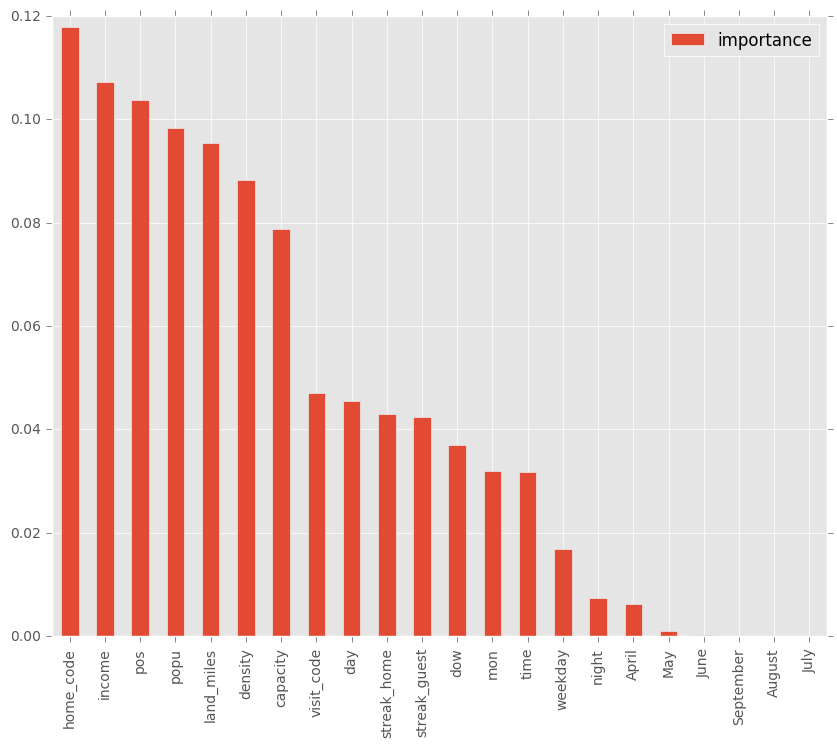

In [488]:
df_.sort("importance", ascending=False).reset_index(drop=True).plot(kind="bar", figsize=(10, 8))
plt.xticks(range(len(df_)), features[indices])
plt.savefig("importance.png", dpi=600)

In [499]:
cv_rf.best_estimator_.decision_path

<bound method BaseForest.decision_path of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=150, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)>

In [519]:
from sklearn.externals.six import StringIO
from sklearn import tree
from IPython.display import Image
import pydotplus
from graphviz import Digraph
dot = Digraph(comment='The Round Table')

In [503]:
tf = DTC(max_depth=10, max_features="sqrt",
         min_samples_split=2, min_samples_leaf=1,
         min_weight_fraction_leaf=0.0).fit(Xtrain, y_train)

In [523]:
dot_data = StringIO()
tree.export_graphviz(tf, out_file="tree.dot",
                     feature_names=features,
                     class_names=["Not full", "Crowded"],
                     filled=True, rounded=True,
                     special_characters=True)